In [ ]:
# default_exp trainers
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import FRED
from FRED.trainers import *
from FRED.trainers import Trainer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
%load_ext autoreload
%autoreload 2

: 

# 04c01 Trainer: Flow Neighbor Loss and distance regularization
> A copy of FRED, tailored with particular loss functions

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points
title = "Flow Neighbor Loss + Diffusion Map Reg"
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[3, 4, 8, 4, 2],
            device=device,
            sigma=0.5,
            flow_strength=0.5,
            smoothness_grid=True,
        )
loss_weights = {
            "reconstruction": 1,
            "distance regularization": 1,
            "kld": 0,
            "smoothness": 0,
            "flow neighbor loss": 1,
        }
visualization_functions = [
    save_embedding_visualization,
    visualize_points
]
FREDtrainer = Trainer(FE = MFE, loss_weights=loss_weights, visualization_functions = visualization_functions, device=device, title = title)

: 

# Testing on the Circle

In [ ]:
from FRED.datasets import directed_circle
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
X, flow, labels = directed_circle(num_nodes=2000)
# build dataset
ds = ManifoldWithVectorField(X, flow, labels, sigma="automatic", dmap_coords_to_use=2, nbhd_strategy="flow neighbors", n_neighbors=10)
dataloader = DataLoader(ds, batch_size=None, shuffle=True)

: 

In [ ]:
FREDtrainer.fit(dataloader, n_epochs = 10)

: 

In [ ]:
FREDtrainer.visualize_loss()

: 

In [ ]:
FREDtrainer.training_gif(duration=150)

: 

In [ ]:
%load_ext snakeviz
%prun -D fredstats.prof FREDtrainer.fit(dataloader, n_epochs = 10)

: 

# Testing on the Swiss Roll

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points
title = "Flow Neighbor Loss + Diffusion Map Reg"
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[3, 4, 8, 4, 2],
            device=device,
            sigma=0.5,
            flow_strength=0.5,
            smoothness_grid=True,
        )
loss_weights = {
            "reconstruction": 1e-3,
            "distance regularization": 1,
            "flow neighbor loss": 1e-4,
            "smoothness": 0,
        }
visualization_functions = [
    save_embedding_visualization,
    visualize_points
]
FREDtrainer = Trainer(FE = MFE, loss_weights=loss_weights, visualization_functions = visualization_functions, device=device, title = title)

: 

In [ ]:
from FRED.datasets import directed_swiss_roll_delayed
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
X, flow, labels = directed_swiss_roll_delayed(num_nodes=2000)
# build dataset
ds = ManifoldWithVectorField(X, flow, labels, sigma=1.1)
dataloader = DataLoader(ds, batch_size=None, shuffle=True)

: 

Double check that diffusion map makes sense

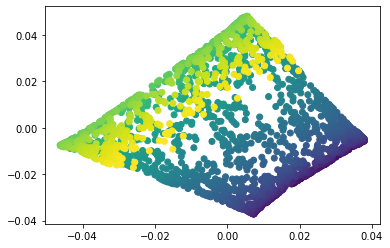

In [ ]:
DC = dataloader.dataset.diff_coords
plt.scatter(DC[:,0],DC[:,1],c=labels)

In [ ]:
FREDtrainer.fit(dataloader, n_epochs = 10)

: 

In [ ]:
FREDtrainer.visualize_loss()

: 

# Double Helix

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points
title = "Flow Neighbor Loss + Diffusion Map Reg"
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[3, 4, 8, 4, 2],
            device=device,
            sigma=0.5,
            flow_strength=0.5,
            smoothness_grid=True,
        )
loss_weights = {
            "reconstruction": 0,
            "distance regularization": 1,
            "flow neighbor loss": 1,
            "smoothness": 0.1,
            "kld": 0,
        }
visualization_functions = [
    save_embedding_visualization,
    visualize_points
]
FREDtrainer = Trainer(FE = MFE, loss_weights=loss_weights, visualization_functions = visualization_functions, device=device, title = title)

: 

In [ ]:
from FRED.datasets import double_helix
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
X, flow, labels = double_helix(num_nodes=2000)
# build dataset
ds = ManifoldWithVectorField(X, flow, labels, sigma="automatic", dmap_coords_to_use=3, nbhd_strategy="flow neighbors", n_neighbors=10)
dataloader = DataLoader(ds, batch_size=None, shuffle=True)

: 

In [ ]:
from FRED.data_processing import affinity_grid_search
affinity_grid_search(X, flow, sigmas = [0.01,0.05,0.1],flow_strengths=[0,0.1,0.5,1])

: 

In [ ]:
from FRED.datasets import plot_directed_3d
plot_directed_3d(X, flow, labels)

: 

In [ ]:
DC = dataloader.dataset.diff_coords
plt.scatter(DC[:,1],DC[:,2],c=labels)

: 

In [ ]:
FREDtrainer.fit(dataloader, n_epochs = 100)

: 

In [ ]:
FREDtrainer.visualize_loss()

: 

In [ ]:
FREDtrainer.training_gif(duration=200)

: 

# Noisy Double Helix

In [ ]:
from FRED.datasets import double_helix, plot_directed_3d
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
X, flow, labels = double_helix(num_nodes=2000, noise=0.5)
# build dataset
ds = ManifoldWithVectorField(X, flow, labels, sigma="automatic", dmap_coords_to_use=3, nbhd_strategy="flow neighbors", n_neighbors=10)
dataloader = DataLoader(ds, batch_size=None, shuffle=True)
plot_directed_3d(X, flow, labels)

: 

In [ ]:
# shuffle X, flows, and labels so that the embeddings don't embed the second class last.
idxs = np.random.randint(0,len(X),len(X))
print(idxs)
X = X[idxs]
flow = flow[idxs]
labels = labels[idxs]
ds = ManifoldWithVectorField(X, flow, labels, sigma="automatic", dmap_coords_to_use=10, nbhd_strategy="flow neighbors", n_neighbors=10, )
dataloader = DataLoader(ds, batch_size=None, shuffle=True)

: 

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points
title = "Flow Neighbor Loss + Diffusion Map Reg"
MFE = ManifoldFlowEmbedder(
    embedding_dimension=2,
    embedder_shape=[3, 4, 8, 4, 2],
    device=device,
    sigma=0.5,
    flow_strength=0.5,
    smoothness_grid=True,
)
loss_weights = {
    "reconstruction": 0,
    "distance regularization": 1,
    "flow neighbor loss": 0,
    "smoothness": 0,
    "kld": 0,
}
visualization_functions = [
    save_embedding_visualization,
    visualize_points
]
FREDtrainer = Trainer(FE = MFE, loss_weights=loss_weights, visualization_functions = visualization_functions, device=device, title = title)

: 

In [ ]:
FREDtrainer.fit(dataloader, n_epochs=100)

: 

In [ ]:
FREDtrainer.visualize_embedding()

: 

In [ ]:
FREDtrainer.training_gif()

: 

: 

: 